# Preprocessing

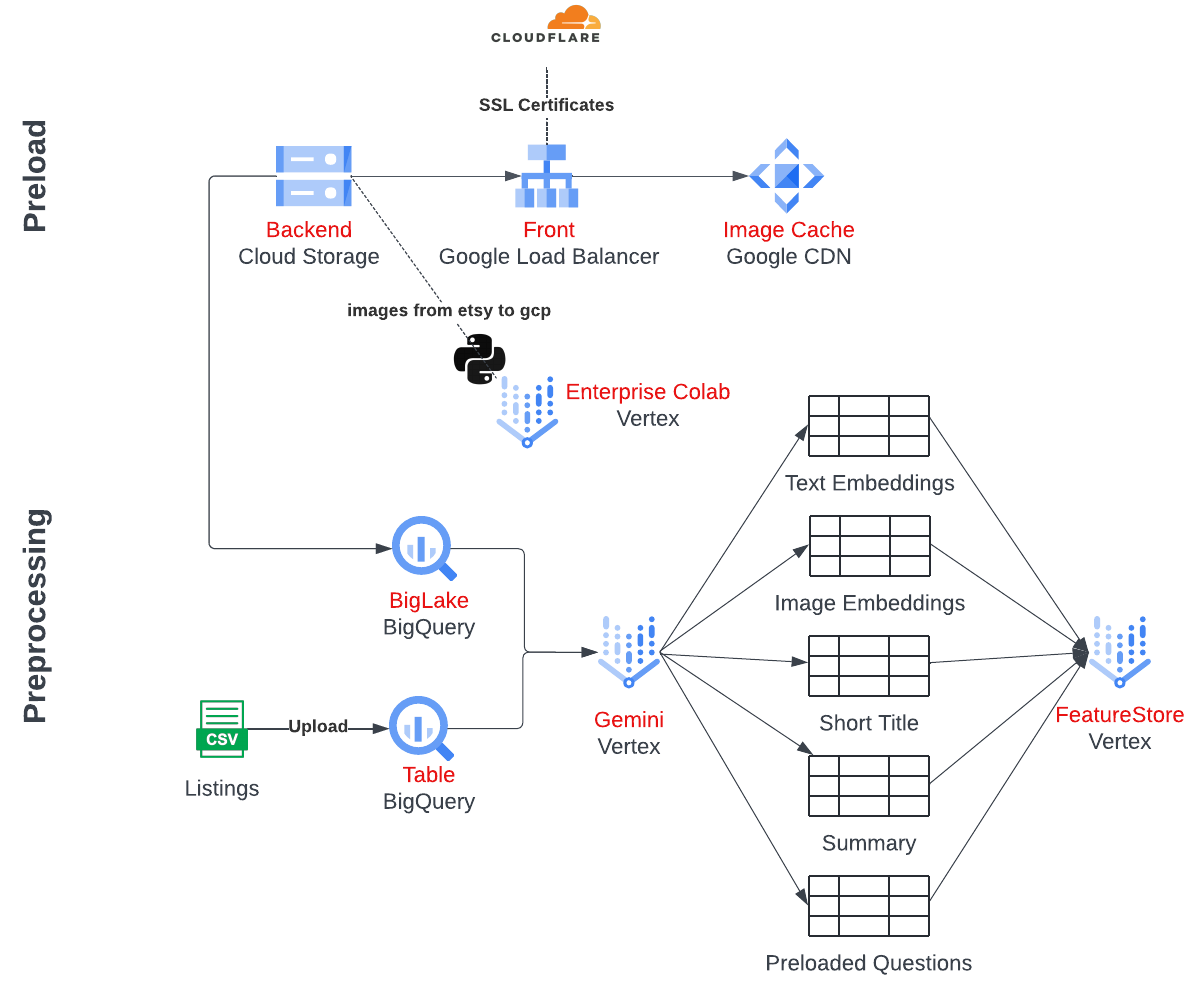

## Set Table and Upload Images to GCS

In [22]:
%%bigquery df

SELECT * EXCEPT(min_price_usd, max_price_usd, pct_discount, variations)
FROM (SELECT * FROM `vtxdemos.demos_us.etsy_10k` LIMIT 2000)
WHERE materials IS NOT NULL AND price_usd IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
from google.cloud import storage
import requests
import os
from urllib.parse import urlparse

bucket_name = "vtxdemos-fstoresearch-datasets"

public_gcs_link = []
private_gcs_link = []
public_cdn_link = []

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

for index, row in df.iterrows():
  url = row["image_url"]
  parsed_url = urlparse(url)
  filename = os.path.basename(parsed_url.path)
  response = requests.get(url)
  blob = bucket.blob("etsy-version1/"+filename)
  blob.upload_from_string(response.content, content_type='image/jpeg')
  public_gcs_link.append(blob.public_url)
  private_gcs_link.append(f"gs://{bucket_name}/etsy-version1/{filename}")
  public_cdn_link.append(f"https://gcpetsy.sonrobots.net/etsy-version1/{filename}")

df["public_gcs_link"] = public_gcs_link
df["private_gcs_link"] = private_gcs_link
df["public_cdn_link"] = public_cdn_link

In [25]:
from google.cloud import bigquery

bq_client = bigquery.Client()
job_config = bigquery.LoadJobConfig()
job = bq_client.load_table_from_dataframe(
    df, "demos_us.etsy-images-version1", job_config=job_config
)
job.result()

LoadJob<project=vtxdemos, location=US, id=3fc84a7f-56a1-4e66-889c-90a9fb21da74>

## Create Unstructured Data Table with Images (BigLake)

In [30]:
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE
  `demos_us.vtxdemos-etsy-images-09112024`
WITH CONNECTION `us.emb_connection`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://vtxdemos-fstoresearch-datasets/etsy-version1/*']
  );

Query is running:   0%|          |

""


In [38]:
%%bigquery
CREATE OR REPLACE TABLE
  `demos_us.etsy-embeddings-full-version1` AS (
  WITH
    text_embeddings AS (
    SELECT
      *
    FROM
      ML.GENERATE_TEXT_EMBEDDING(MODEL demos_us.text_embedding_044,
        (
        SELECT
          *,
          (CONCAT( "listing id: ", IFNULL(CAST(listing_id AS STRING), ""), " title of the listing: ", IFNULL(title, ""), " the price in US dollars: ", IFNULL(CAST(price_usd AS STRING), ""), " the description of the listing: ", IFNULL(description, ""), " tags used for filter: ", IFNULL(tags, ""), " the materials item was made of: ", IFNULL(materials, ""), ", the attributes: ", IFNULL(attributes, ""), ", the price in usd: ", price_usd)) AS content
        FROM
          `demos_us.etsy-images-version1`
        ORDER BY
          private_gcs_link )) ),
    image_embeddings AS (
    SELECT
      *
    FROM
      ML.GENERATE_EMBEDDING( MODEL `vtxdemos.demos_us.multimodalembedding`,
        TABLE `demos_us.vtxdemos-etsy-images-09112024`,
        STRUCT( TRUE AS flatten_json_output ) )
    ORDER BY
      uri),
    questions AS (
    SELECT
      ml_generate_text_llm_result AS llm_questions,
      private_uri AS llm_questions_image_uri
    FROM
      ML.GENERATE_TEXT(MODEL `demos_us.gemini_1_5_pro`,
        ((
          SELECT
            private_gcs_link AS private_uri,
            (CONCAT( """
          The following context is a list of products from Etsy.
          Your task is to create 4 questions that customers might ask based in the following categories:

          <categories>
          category_1: 4 questions that are most likely to be asked from the context itself (answerable with context only).
          category_2: 4 questions that are inspirational based on information on other websites.
          category_3: 4 questions showing other etsy listings or sub-catogories that are similar, relevant, compliment,
          or whatever the LLM suggests to show a relationship with other items.
          </categories>

          <context>\n
          """, "listing id: ", IFNULL(CAST(listing_id AS STRING), ""), " title of the listing: ", IFNULL(title, ""), " the price in US dollars: ", IFNULL(CAST(price_usd AS STRING), ""), " the description of the listing: ", IFNULL(description, ""), " tags used for filter: ", IFNULL(tags, ""), " the materials item was made of: ", IFNULL(materials, ""), ", the attributes: ", IFNULL(attributes, ""),
          "\n</context>\n",
          """
          <rules>
          * Be concise DO NOT use more than 5-6 words.
          * Avoid any markdown or decoration format in your output.
          * Avoid backticks like ```json or ```JSON
          * Return a valid string without any unnecessary escape characters. The structure should be like this:
          {"questions_category_1": ["question1", "question2", ...], "questions_category_2": [...], "questions_category_3": [...]}
          </rules>
          """
          )) AS prompt
          FROM
            `vtxdemos.demos_us.etsy-images-version1`)),
        STRUCT( 0.2 AS temperature,
          TRUE AS FLATTEN_JSON_OUTPUT,
          8192 AS max_output_tokens,
          [ STRUCT('HARM_CATEGORY_DANGEROUS_CONTENT' AS category,
            'BLOCK_NONE' AS threshold),
          STRUCT('HARM_CATEGORY_HATE_SPEECH' AS category,
            'BLOCK_NONE' AS threshold),
          STRUCT('HARM_CATEGORY_HARASSMENT' AS category,
            'BLOCK_NONE' AS threshold),
          STRUCT('HARM_CATEGORY_SEXUALLY_EXPLICIT' AS category,
            'BLOCK_NONE' AS threshold) ] AS safety_settings ) ) )
  SELECT
    te.*,
    ie.*,
    q.*
  FROM
    text_embeddings te
  INNER JOIN
    image_embeddings ie
  ON
    te.private_gcs_link = ie.uri
  INNER JOIN
    questions q
  ON
    te.private_gcs_link = q.llm_questions_image_uri )

Query is running:   0%|          |

""


In [42]:
%%bigquery df_full
SELECT * FROM `demos_us.etsy-embeddings-full-version1` WHERE llm_questions IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   text_embedding                   1202 non-null   object             
 1   statistics                       1202 non-null   object             
 2   ml_embed_text_status             1202 non-null   object             
 3   listing_id                       1202 non-null   Int64              
 4   title                            1202 non-null   object             
 5   description                      1202 non-null   object             
 6   price_usd                        1202 non-null   float64            
 7   tags                             1108 non-null   object             
 8   materials                        1202 non-null   object             
 9   attributes                       1202 non-null   object             
 10  

## Title and Summary

In [45]:
%%bigquery
CREATE OR REPLACE TABLE `demos_us.etsy-embeddings-full-version1-title` AS (
SELECT
  ml_generate_text_llm_result AS llm_title,
  * EXCEPT (prompt,
    ml_generate_text_status, ml_generate_text_llm_result, ml_generate_text_rai_result)
FROM
  ML.GENERATE_TEXT( MODEL `demos_us.gemini15`,
    (
    SELECT
      *,
      CONCAT("From the following text, create a short title, NO MORE than 4 words: text: ", title, " 4 words only output:") AS prompt
    FROM
      `demos_us.etsy-embeddings-full-version1` WHERE llm_questions IS NOT NULL),
    STRUCT( 0.2 AS temperature,
      TRUE AS FLATTEN_JSON_OUTPUT ))
)

Query is running:   0%|          |

""


In [46]:
%%bigquery
CREATE OR REPLACE TABLE `demos_us.etsy-embeddings-full-version1-title` AS (
SELECT
  ml_generate_text_llm_result AS summary,
  * EXCEPT (prompt,
    ml_generate_text_status, ml_generate_text_llm_result, ml_generate_text_rai_result)
FROM
  ML.GENERATE_TEXT( MODEL `demos_us.gemini15`,
    (
    SELECT
      *,
      CONCAT("From the following context, create a brief summary: context: ", content) AS prompt
    FROM
      `demos_us.etsy-embeddings-full-version1-title`
      ),
    STRUCT( 0.2 AS temperature,
      TRUE AS FLATTEN_JSON_OUTPUT ))
)

Query is running:   0%|          |

""


In [50]:
%%bigquery df_title
SELECT * FROM `demos_us.etsy-embeddings-full-version1-title`

Query is running:   0%|          |

Downloading:   0%|          |

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        1205 non-null   Int64  
 1   title             1205 non-null   object 
 2   description       1205 non-null   object 
 3   price_usd         1205 non-null   float64
 4   tags              1111 non-null   object 
 5   materials         1205 non-null   object 
 6   attributes        1205 non-null   object 
 7   image_url         1205 non-null   object 
 8   listing_id_1      1205 non-null   Int64  
 9   taxonomy_id       1205 non-null   Int64  
 10  category          1205 non-null   object 
 11  public_gcs_link   1205 non-null   object 
 12  private_gcs_link  1205 non-null   object 
 13  public_cdn_link   1205 non-null   object 
dtypes: Int64(3), float64(1), object(10)
memory usage: 135.5+ KB


## Create Feature Store

In [49]:
from vertexai.resources.preview import feature_store

In [52]:
feature_store_online_id = "fs_etsy"

In [57]:
fos = feature_store.FeatureOnlineStore(name="projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy")

In [56]:
%%bigquery

CREATE OR REPLACE TABLE
  `demos_us.etsy-embeddings-full-version1-latest` AS (
  SELECT
    CAST(ROW_NUMBER() OVER() AS STRING) AS unique_id,
    -- Assigns unique ID starting from 1
    llm_title,
    summary,
    text_embedding,
    ml_embed_text_status,
    listing_id,
    title,
    price_usd,
    description,
    tags,
    materials,
    attributes,
    image_url,
    public_gcs_link,
    private_gcs_link,
    public_cdn_link,
    content,
    ml_generate_embedding_result,
    uri,
    generation,
    content_type,
    size,
    updated,
    llm_questions,
    llm_questions_image_uri
  FROM
    `demos_us.etsy-embeddings-full-version1-title`)

Query is running:   0%|          |

""


## Indexing for Text Embeddings

In [59]:
import time

start_time = time.time()
bigquery_source = feature_store.utils.FeatureViewBigQuerySource(
        uri="bq://vtxdemos.demos_us.etsy-embeddings-full-version1-latest",
        entity_id_columns=["unique_id"],
    )
index_config = feature_store.utils.IndexConfig(
    embedding_column="text_embedding",
    dimensions=768,
    algorithm_config=feature_store.utils.TreeAhConfig(),
)

fv = fos.create_feature_view(
    name="fs_etsy_view_text_emb_version1",
    source=bigquery_source,
    index_config=index_config,
)
print(time.time() - start_time)

INFO:vertexai.resources.preview.feature_store.feature_online_store:Creating FeatureView
INFO:vertexai.resources.preview.feature_store.feature_online_store:Create FeatureView backing LRO: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb_version1/operations/6595430566617677824
INFO:vertexai.resources.preview.feature_store.feature_online_store:FeatureView created. Resource name: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb_version1
INFO:vertexai.resources.preview.feature_store.feature_online_store:To use this FeatureView in another session:
INFO:vertexai.resources.preview.feature_store.feature_online_store:feature_view = aiplatform.FeatureView('projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb_version1')


1.6141507625579834


In [60]:
sync_response = fv.sync()

In [61]:
import time

start_time = time.time()
while True:
    feature_view_sync = fv.get_sync(
        sync_response.resource_name.split("/")[9]
    ).gca_resource
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}. \n {feature_view_sync}")
        # wait a little more for the job to properly shutdown
        time.sleep(30)
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)
print(time.time() - start_time)

Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync Succeed for projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb_version1/featureViewSyncs/2218961507352313856. 
 name: "projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb_version1/featureViewSyncs/2218961507352313856"
create_time {
  seconds: 1726140947
  nanos: 26190000
}
run_time {
  start_time {
    seconds: 1726140947
    nanos: 26190000
  }
  end_time {
    seconds: 1726141136
    nanos: 559329000
  }
}
final_status {
}
sync_summary {
  row_synced: 3606
  total_slot: 11846
}

210.89813256263733


## Indexing for Multimodal Embeddings

In [69]:
import time

start_time = time.time()
bigquery_source = feature_store.utils.FeatureViewBigQuerySource(
        uri="bq://vtxdemos.demos_us.etsy-embeddings-full-version1-latest",
        entity_id_columns=["unique_id"],
    )
index_config = feature_store.utils.IndexConfig(
    embedding_column="ml_generate_embedding_result",
    dimensions=1408,
    algorithm_config=feature_store.utils.TreeAhConfig(),
)

fv = fos.create_feature_view(
    name="fs_etsy_view_multimodal_embe_version1",
    source=bigquery_source,
    index_config=index_config,
)
print(time.time() - start_time)

INFO:vertexai.resources.preview.feature_store.feature_online_store:Creating FeatureView
INFO:vertexai.resources.preview.feature_store.feature_online_store:Create FeatureView backing LRO: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_embe_version1/operations/5961760025297813504
INFO:vertexai.resources.preview.feature_store.feature_online_store:FeatureView created. Resource name: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_embe_version1
INFO:vertexai.resources.preview.feature_store.feature_online_store:To use this FeatureView in another session:
INFO:vertexai.resources.preview.feature_store.feature_online_store:feature_view = aiplatform.FeatureView('projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_embe_version1')


1.352574110031128


In [70]:
sync_response = fv.sync()

In [71]:
import time

start_time = time.time()
while True:
    feature_view_sync = fv.get_sync(
        sync_response.resource_name.split("/")[9]
    ).gca_resource
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}. \n {feature_view_sync}")
        # wait a little more for the job to properly shutdown
        time.sleep(30)
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)
print(time.time() - start_time)

Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync Succeed for projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_embe_version1/featureViewSyncs/6295141382587678720. 
 name: "projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_embe_version1/featureViewSyncs/6295141382587678720"
create_time {
  seconds: 1726141881
  nanos: 20292000
}
run_time {
  start_time {
    seconds: 1726141881
    nanos: 20292000
  }
  end_time {
    seconds: 1726142070
    nanos: 848866000
  }
}
final_status {
}
sync_summary {
  row_synced: 3606
  total_slot: 7370
}

240.94763016700745
